#### Project - Featurization, Model Selection and Tuning

### Project & Data Information

<span style="font-family: Arial; font-weight:bold;font-size:1.1em;color:#666666"> `DOMAIN`: Semiconductor manufacturing process.
    
<span style="font-family: Arial; font-weight:bold;font-size:1.1em;color:#666666"> `CONTEXT`: A complex modern semiconductor manufacturing process is normally under constant surveillance via the monitoring of
signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs. These signals can be used as features to predict the yield type. And by analysing and trying out different combinations of features, essential signals that are impacting the yield type can be identified.
    
<span style="font-family: Arial; font-weight:bold;font-size:1.1em;color:#666666"> `DATA DESCRIPTION`: signal-data.csv : (1567, 592)
The data consists of 1567 datapoints each with 591 features.
The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.    
    
<span style="font-family: Arial; font-weight:bold;font-size:1.1em;color:#666666"> `PROJECT OBJECTIVE`: We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the features are required to build the model or not.

### Importing all necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import uniform, randint
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, StratifiedKFold

### <span style="font-family: Arial; font-weight:bold;font-size:2em;color:#556B2F;"> 1. Data Understanding

### 1 A - Import ‘signal-data.csv’ as DataFrame.

In [2]:
df = pd.read_csv('signal-data.csv')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df.head()

Time        0        1          2          3       4      5  \
0  2008-07-19 11:55:00  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1  2008-07-19 12:32:00  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2  2008-07-19 13:17:00  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3  2008-07-19 14:43:00  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4  2008-07-19 15:22:00  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   

          6       7       8       9      10      11        12   13       14  \
0   97.6133  0.1242  1.5005  0.0162 -0.0034  0.9455  202.4396  0.0   7.9558   
1  102.3433  0.1247  1.4966 -0.0005 -0.0148  0.9627  200.5470  0.0  10.1548   
2   95.4878  0.1241  1.4436  0.0041  0.0013  0.9615  202.0179  0.0   9.5157   
3  104.2367  0.1217  1.4882 -0.0124 -0.0033  0.9629  201.8482  0.0   9.6052   
4  100.3967  0.1235  1.5031 -0.0031 -0.0072  0.9569  201.9424  0.0  10.5661   

         15       16      17        18       19      20       21       22  \
0  414.8710  10.0433  0.9680  192.3963  12.5190  1.4026 -5419.00  2916.50   
1  414.7347   9.2599  0.9701  191.2872  12.4608  1.3825 -5441.50  2604.25   
2  416.7075   9.3144  0.9674  192.7035  12.5404  1.4123 -5447.75  2701.75   
3  422.2894   9.6924  0.9687  192.1557  12.4782  1.4011 -5468.25  2648.25   
4  420.5925  10.3387  0.9735  191.6037  12.4735  1.3888 -5476.25  2635.25   

        23       24      25      26      27       28      29      30      31  \
0 -4043.75   751.00  0.8955  1.7730  3.0490  64.2333  2.0222  0.1632  3.5191   
1 -3498.75 -1640.25  1.2973  2.0143  7.3900  68.4222  2.2667  0.2102  3.4171   
2 -4047.00 -1916.50  1.3122  2.0295  7.5788  67.1333  2.3333  0.1734  3.5986   
3 -4515.00 -1657.25  1.3137  2.0038  7.3145  62.9333  2.6444  0.2071  3.3813   
4 -3987.50   117.00  1.2887  1.9912  7.2748  62.8333  3.1556  0.2696  3.2728   

        32      33       34       35       36       37       38        39  \
0  83.3971  9.5126  50.6170  64.2588  49.3830  66.3141  86.9555  117.5132   
1  84.9052  9.7997  50.6596  64.2828  49.3404  64.9193  87.5241  118.1188   
2  84.7569  8.6590  50.1530  64.1114  49.8470  65.8389  84.7327  118.6128   
3  84.9105  8.6789  50.5100  64.1125  49.4900  65.1951  86.6867  117.0442   
4  86.3269  8.7677  50.2480  64.1511  49.7520  66.1542  86.1468  121.4364   

      40     41    42        43       44        45        46      47  \
0  61.29  4.515  70.0  352.7173  10.1841  130.3691  723.3092  1.3072   
1  78.25  2.773  70.0  352.2445  10.0373  133.1727  724.8264  1.2887   
2  14.37  5.434  70.0  364.3782   9.8783  131.8027  734.7924  1.2992   
3  76.90  1.279  70.0  363.0273   9.9305  131.8027  733.8778  1.3027   
4  76.39  2.209  70.0  353.3400  10.4091  176.3136  789.7523  1.0341   

         48   49        50        51   52     53     54      55      56  \
0  141.2282  1.0  624.3145  218.3174  0.0  4.592  4.841  2834.0  0.9317   
1  145.8445  1.0  631.2618  205.1695  0.0  4.590  4.842  2853.0  0.9324   
2  141.0845  1.0  637.2655  185.7574  0.0  4.486  4.748  2936.0  0.9139   
3  142.5427  1.0  637.3727  189.9079  0.0  4.486  4.748  2936.0  0.9139   
4  138.0882  1.0  667.7418  233.5491  0.0  4.624  4.894  2865.0  0.9298   

       57      58       59        60       61        62       63       64  \
0  0.9484  4.7057  -1.7264  350.9264  10.6231  108.6427  16.1445  21.7264   
1  0.9479  4.6820   0.8073  352.0073  10.3092  113.9800  10.9036  19.1927   
2  0.9447  4.5873  23.8245  364.5364  10.1685  115.6273  11.3019  16.1755   
3  0.9447  4.5873  24.3791  361.4582  10.2112  116.1818  13.5597  15.6209   
4  0.9449  4.6414 -12.2945  355.0809   9.7948  144.0191  21.9782  32.2945   

        65        66      67        68   69        70       71        72  \
0  29.5367  693.7724  0.9226  148.6009  1.0  608.1700  84.0793       NaN   
1  27.6301  697.1964  1.1598  154.3709  1.0  620.3582  82.3494       NaN   
2  24.2829  710.5095  0.8694  145.8000  1.0  625.9636  84.7681  140.6972  

Let's look at the basic information of the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


### 1 B - Print 5 point summary and share at least 2 observations.

In [5]:
df.describe()

0            1            2            3            4  \
count  1561.000000  1560.000000  1553.000000  1553.000000  1553.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.621787    80.407705    29.513152   441.691640    56.355540   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.260000  2452.247500  2181.044400  1081.875800     1.017700   
50%    3011.490000  2499.405000  2201.066700  1285.214400     1.316800   
75%    3056.650000  2538.822500  2218.055500  1591.223500     1.525700   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

            5            6            7            8            9  \
count  1553.0  1553.000000  1558.000000  1565.000000  1565.000000   
mean    100.0   101.112908     0.121822     1.462862    -0.000841   
std       0.0     6.237214     0.008961     0.073897     0.015116   
min     100.0    82.131100     0.000000     1.191000    -0.053400   
25%     100.0    97.920000     0.121100     1.411200    -0.010800   
50%     100.0   101.512200     0.122400     1.461600    -0.001300   
75%     100.0   104.586700     0.123800     1.516900     0.008400   
max     100.0   129.252200     0.128600     1.656400     0.074900   

                10           11           12      13           14  \
count  1565.000000  1565.000000  1565.000000  1564.0  1564.000000   
mean      0.000146     0.964353   199.956809     0.0     9.005371   
std       0.009302     0.012452     3.257276     0.0     2.796596   
min      -0.034900     0.655400   182.094000     0.0     2.249300   
25%      -0.005600     0.958100   198.130700     0.0     7.094875   
50%       0.000400     0.965800   199.535600     0.0     8.967000   
75%       0.005900     0.971300   202.007100     0.0    10.861875   
max       0.053000     0.984800   272.045100     0.0    19.546500   

                15           16           17           18           19  \
count  1564.000000  1564.000000  1564.000000  1564.000000  1557.000000   
mean    413.086035     9.907603     0.971444   190.047354    12.481034   
std      17.221095     2.403867     0.012062     2.781041     0.217965   
min     333.448600     4.469600     0.579400   169.177400     9.877300   
25%     406.127400     9.567625     0.968200   188.299825    12.460000   
50%     412.219100     9.851750     0.972600   189.664200    12.499600   
75%     419.089275    10.128175     0.976800   192.189375    12.547100   
max     824.927100   102.867700     0.984800   215.597700    12.989800   

                20           21           22           23            24  \
count  1567.000000  1565.000000  1565.000000  1565.000000   1565.000000   
mean      1.405054 -5618.393610  2699.378435 -3806.299734   -298.598136   
std       0.016737   626.822178   295.498535  1380.162148   2902.690117   
min       1.179700 -7150.250000     0.000000 -9986.750000 -14804.500000   
25%       1.396500 -5933.250000  2578.000000 -4371.750000  -1476.000000   
50%       1.406000 -5523.250000  2664.000000 -3820.750000    -78.750000   
75%       1.415000 -5356.250000  2841.750000 -3352.750000   1377.250000   
max       1.453400     0.000000  3656.250000  2363.000000  14106.000000   

                25           26           27           28           29  \
count  1565.000000  1565.000000  1565.000000  1565.000000  1565.000000   
mean      1.203845     1.938477     6.638628    69.499532     2.366197   
std       0.177600     0.189495     1.244249     3.461181     0.408694   
min       0.000000     0.000000     0.000000    59.400000     0.666700   
25%       1.094800     1.906500     5.263700    67.377800     2.088900   
50%       1.283000     1.986500     7.264700    69.155600     2.377800   
75%       1.304300     2.003200     7.329700    72.266700     2.655600   
max       1.382800     2.052800     7.658800    77.900000     3.511100   

                30           31           32           33           34  \
count  1565.000000  15

### Observations -

* `Missing Values`: The difference in row counts for each feature indicates that some features have missing values. The count of non-null values for each feature is the number of data points available for analysis. Features with fewer non-null values might have missing data that needs to be addressed before building a machine learning model.

* `Features with Varying Ranges`: Looking at the "min" and "max" values for different features, we can see that the ranges of values vary significantly between features.

* `Constant Values`: Some features have constant values like - '1', '100', '0' throughout with zero standard deviation indicating that these features doesn't seem to have any variability and might not contribute much information for the predictive model. It could potentially be considered for removal during feature selection.

### <span style="font-family: Arial; font-weight:bold;font-size:2em;color:#556B2F;"> 2. Data Cleansing

### 2 A - Write a for loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature.

In [6]:
null_threshold = 0.2

for column in df.columns:
    # Calculate the percentage of null values in the column
    null_percentage = df[column].isnull().sum() / len(df)
    
    # Check if the column is numeric and null percentage is above the threshold
    if df[column].dtype != 'object' and null_percentage >= null_threshold:
        df.drop(column, axis=1, inplace=True, )
    elif df[column].dtype != 'object':
        # Impute the null values with the mean of the column
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)

Now to verify it let's check the number of features present.

In [7]:
print('Number of features present after this step: ',df.shape[1])

Number of features present after this step:  560


Therefore, columns with 20%+ missing values have been removed.

### 2 B - Identify and drop the features which are having same value for all the rows.

Here basically we have to check for the features having zero standard deviation and drop them from the dataset, if any.

In [8]:
df.drop(columns=['Time'], inplace=True)

# Calculates the standard deviation for each column
std_dev = df.std()

# Identify columns with standard deviation of zero (all values are the same)
same_value_columns = std_dev[std_dev == 0].index

# Drop columns with zero standard deviation
df.drop(columns=same_value_columns, inplace=True)

df.fillna(df.mean(), inplace=True)

Let's verify this by checking the no.of features present after this process.

In [9]:
print('Number of features present after this step: ',df.shape[1])

Number of features present after this step:  443


Therefore all the features with same values for all the rows have been dropped.

### 2 C - Drop other features if required using relevant functional knowledge. Clearly justify the same.

Let's now look at the statistical summary of the data.

In [10]:
df.describe()

0            1            2            3            4  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.480613    80.227793    29.380932   439.712852    56.103066   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.665000  2452.885000  2181.099950  1083.885800     1.017700   
50%    3011.840000  2498.910000  2200.955600  1287.353800     1.317100   
75%    3056.540000  2538.745000  2218.055500  1590.169900     1.529600   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

                 6            7            8            9           10  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean    101.112908     0.121822     1.462862    -0.000841     0.000146   
std       6.209271     0.008936     0.073849     0.015107     0.009296   
min      82.131100     0.000000     1.191000    -0.053400    -0.034900   
25%      97.937800     0.121100     1.411250    -0.010800    -0.005600   
50%     101.492200     0.122400     1.461600    -0.001300     0.000400   
75%     104.530000     0.123800     1.516850     0.008400     0.005900   
max     129.252200     0.128600     1.656400     0.074900     0.053000   

                11           12           14           15           16  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean      0.964353   199.956809     9.005371   413.086035     9.907603   
std       0.012444     3.255195     2.793916    17.204591     2.401563   
min       0.655400   182.094000     2.249300   333.448600     4.469600   
25%       0.958100   198.130950     7.096750   406.131000     9.568550   
50%       0.965800   199.537100     8.973900   412.262900     9.852000   
75%       0.971300   202.006750    10.858700   419.082800    10.127750   
max       0.984800   272.045100    19.546500   824.927100   102.867700   

                17           18           19           20           21  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean      0.971444   190.047354    12.481034     1.405054 -5618.393610   
std       0.012051     2.778376     0.217268     0.016737   626.421781   
min       0.579400   169.177400     9.877300     1.179700 -7150.250000   
25%       0.968250   188.300650    12.460000     1.396500 -5932.625000   
50%       0.972500   189.675700    12.499600     1.406000 -5523.250000   
75%       0.976800   192.178900    12.547100     1.415000 -5356.625000   
max       0.984800   215.597700    12.989800     1.453400     0.000000   

                22           23            24           25           26  \
count  1567.000000  1567.000000   1567.000000  1567.000000  1567.000000   
mean   2699.378435 -3806.299734   -298.598136     1.203845     1.938477   
std     295.309778  1379.280537   2900.835956     0.177487     0.189374   
min       0.000000 -9986.750000 -14804.500000     0.000000     0.000000   
25%    2578.125000 -4370.625000  -1474.375000     1.094900     1.906750   
50%    2664.000000 -3819.750000    -80.500000     1.283000     1.986300   
75%    2840.625000 -3356.375000   1376.250000     1.304300     2.003200   
max    3656.250000  2363.000000  14106.000000     1.382800     2.052800   

                27           28           29           30           31  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean      6.638628    69.499532     2.366197     0.184159     3.673189   
std       1.243454     3.458970     0.408433     0.032923     0.534980   
min       0.000000    59.400000     0.666700     0.034100     2.069800   
25%       5.267350    67.383350     2.088900     0.161800     3.362700   
50%       7.264500    69.155600     2.377800     0.186700     3.431400   
75%       7.329600    72.255550     2.655600     0.207000     3.533500   
max       7.658800    77.900000     3.511100     0.285100     4.804400   

      

By visually looking at the statistical summary of the data its is difficult to say if the features are relevent or not so i would like to retain all the features for now based on the following assumptions/reasons -

1. `Domain Relevance`: All features are directly relevant to the domain and problem at hand. Each feature contributes unique information that can help the model understand patterns and relationships.

2. `Predictive Power`: All features are statistically significant and have demonstrated predictive power in preliminary analyses. Removing any of them might result in loss of predictive accuracy.

### 2 D - Check for multi-collinearity in the data and take necessary action.

Let's check for the multi-collinearity in the data using VIF (Variance Inflation Factor) and then drop the features accordingly.

If a feature has a very high VIF (usually above 5-10), it indicates strong multicollinearity and we might consider removing such features.

In [11]:
df_vif = df.select_dtypes(include=['float64', 'int64'])
df_vif = df_vif.drop(columns=['Pass/Fail'])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(len(df_vif.columns))]

# Find features with high VIF (indicating multicollinearity)
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"]

features_to_drop = high_vif_features.tolist() 
df.drop(columns=features_to_drop, inplace=True)

Let's now verify the above process.

In [12]:
print("Shape after dropping features:", df.shape)

Shape after dropping features: (1567, 40)


##### We can notice that the number of features have reduced drastically indicating strong multi-collinearity among majority of features.

### 2 E - Make all relevant modifications on the data using both functional/logical reasoning/assumptions.

#### Modifications Made:

1. `2A - Dropping Irrelevant Columns (Non-numeric and 'Time' Column)`:

Assumption: Non-numeric columns and the 'Time' column are not relevant for predictive modeling, and dropping them simplifies the dataset.

2. `2B - Dropping Features with Same Value and Zero Standard Deviation`:

Assumption: Features with the same value for all instances provide no variation and do not contribute meaningful information to the model. Features with zero standard deviation also do not vary across instances.

3. `2C - Dropping Features with High Multicollinearity`:

Assumption: High multicollinearity among features can lead to unstable coefficient estimates and model complexity. Dropping highly correlated features improves model interpretability and stability.

4. `2D - Checking and Addressing Multicollinearity using VIF`:

Assumption: Detecting and addressing multicollinearity ensures that the model's coefficient estimates are more stable and interpretable.

#### Assumptions and Explanations:

* `Irrelevance and Noise`: The steps taken in 2A, 2B, and 2C are focused on removing irrelevant features, features with low variation, and highly correlated features. These steps aim to reduce noise and simplify the dataset, leading to a more efficient and effective modeling process.

* `Multicollinearity and Model Stability`: High multicollinearity can lead to issues in coefficient interpretation and prediction. By checking for multicollinearity and dropping problematic features (2D), the goal is to create a more stable and reliable model.

#### Scope for further Feature Engineering:

* `Feature Scaling`: We can consider scaling the features to a common scale (e.g., StandardScaler or MinMaxScaler). This can improve the convergence of certain algorithms.
* `Dimensionality Reduction (PCA)`: Since we have already addressed multicollinearity and dropped some features, there's still a scope for exploring Principal Component Analysis (PCA) to reduce dimensionality further and capture the most important variance while minimizing multicollinearity. This can improve model efficiency and mitigate overfitting.

#### Assumptions on Cleaned Data:

* The cleaned data is now more suitable for building predictive models due to the removal of irrelevant, redundant, and highly correlated features.
* Model interpretability and stability are enhanced by reducing noise and multicollinearity.
* The dataset now aligns more closely with the problem's requirements, improving the chances of successful model training and validation.

### <span style="font-family: Arial; font-weight:bold;font-size:2em;color:#556B2F;"> 3. Data Analysis & Visualisation

### 3 A - Perform a detailed univariate Analysis with appropriate detailed comments after each analysis.

##### Let's first look at the distribution plot for the features that wil help us understand the distribution shape, central tendency, and spread of the variables. 

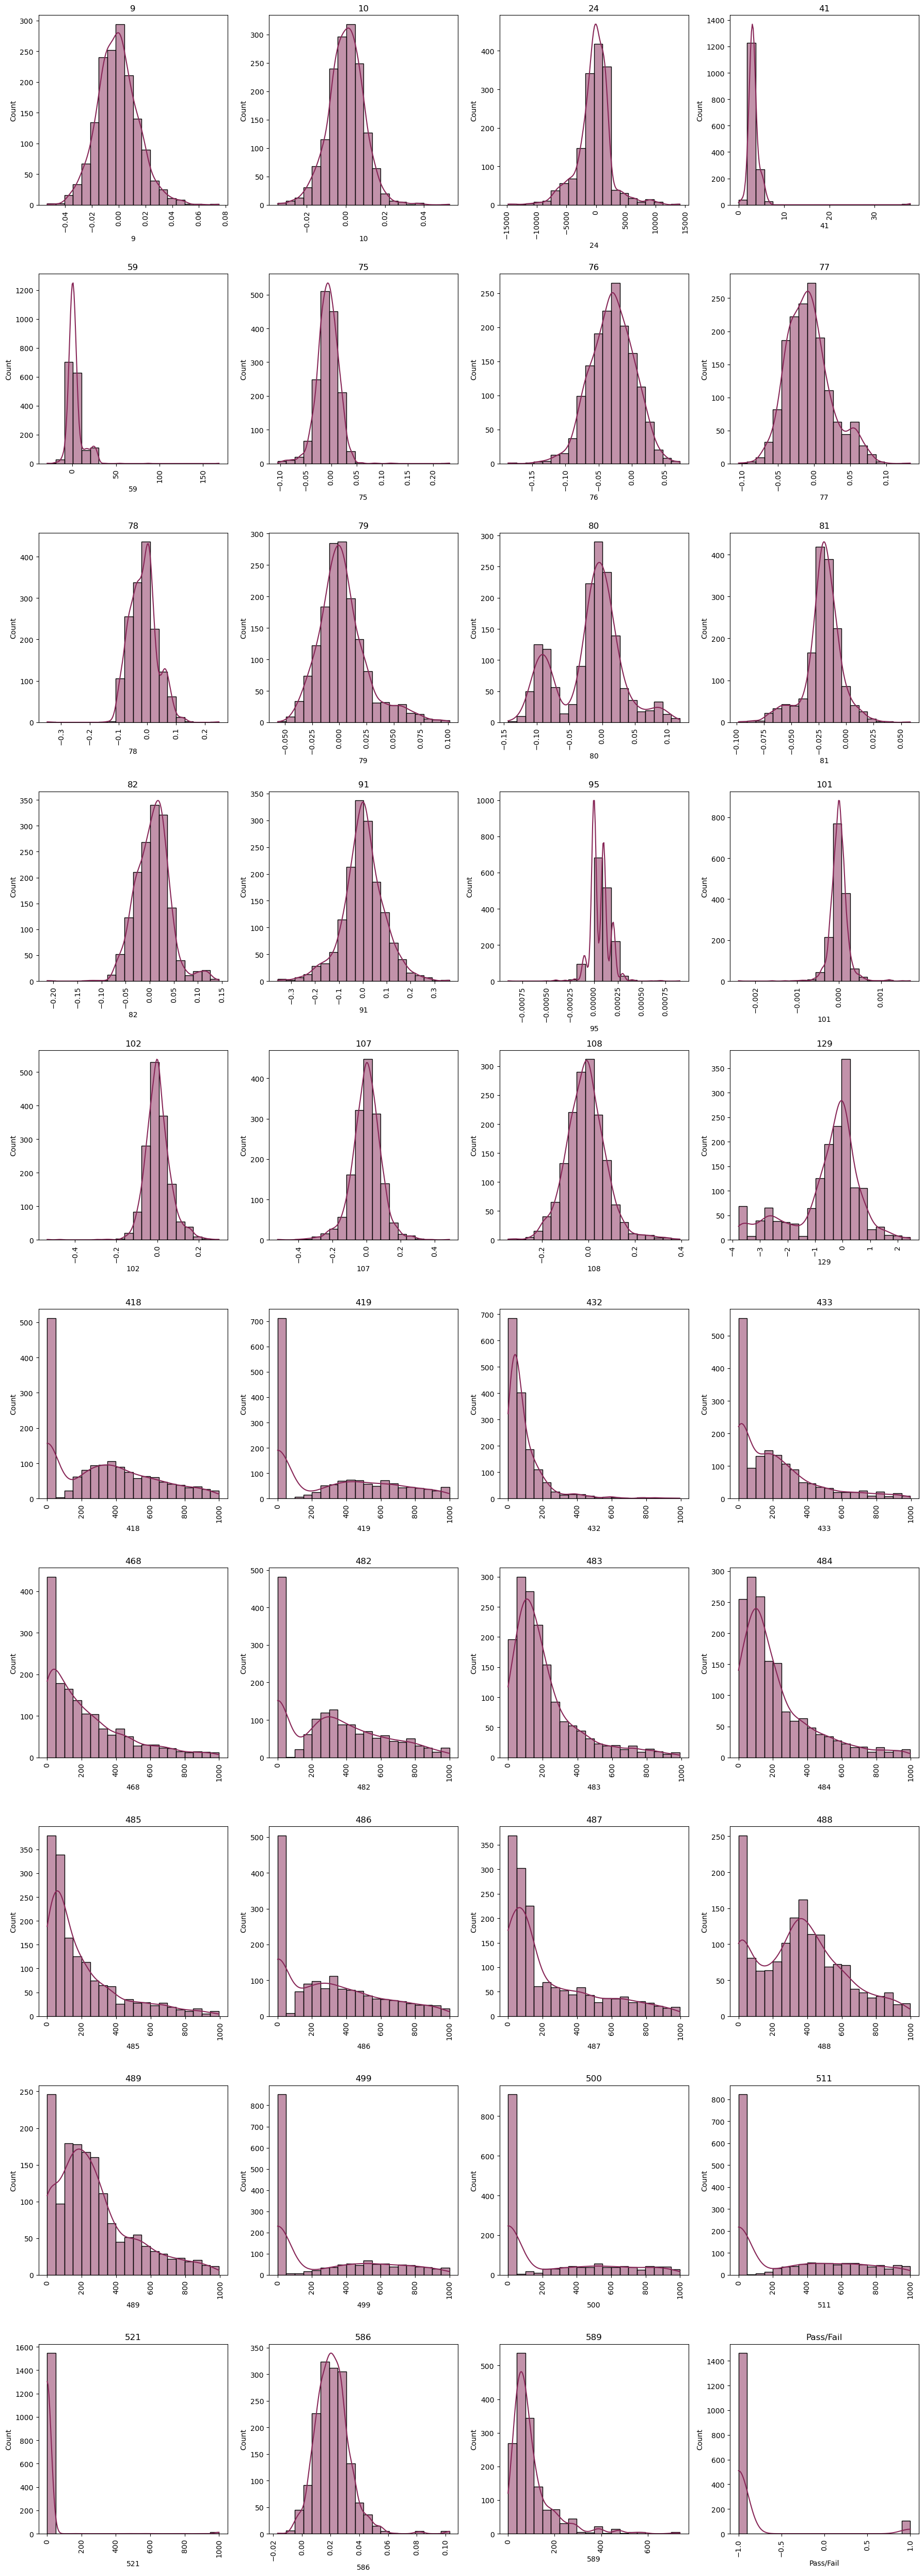

In [13]:
num_cols = df.select_dtypes(include=['float64', 'int64'])
num_features = num_cols.columns
num_features_count = len(num_features)

n_rows = (num_features_count - 1) // 4 + 1
n_cols = min(num_features_count, 4)

plt.figure(figsize=(18, 5 * n_rows))
for i, var in enumerate(num_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[var], bins=20, kde=True, color='#872657')
    plt.title(var)
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

##### Let's now look ath the boxplot for each of the features which would be helpful for visualizing the spread and identifying outliers.  

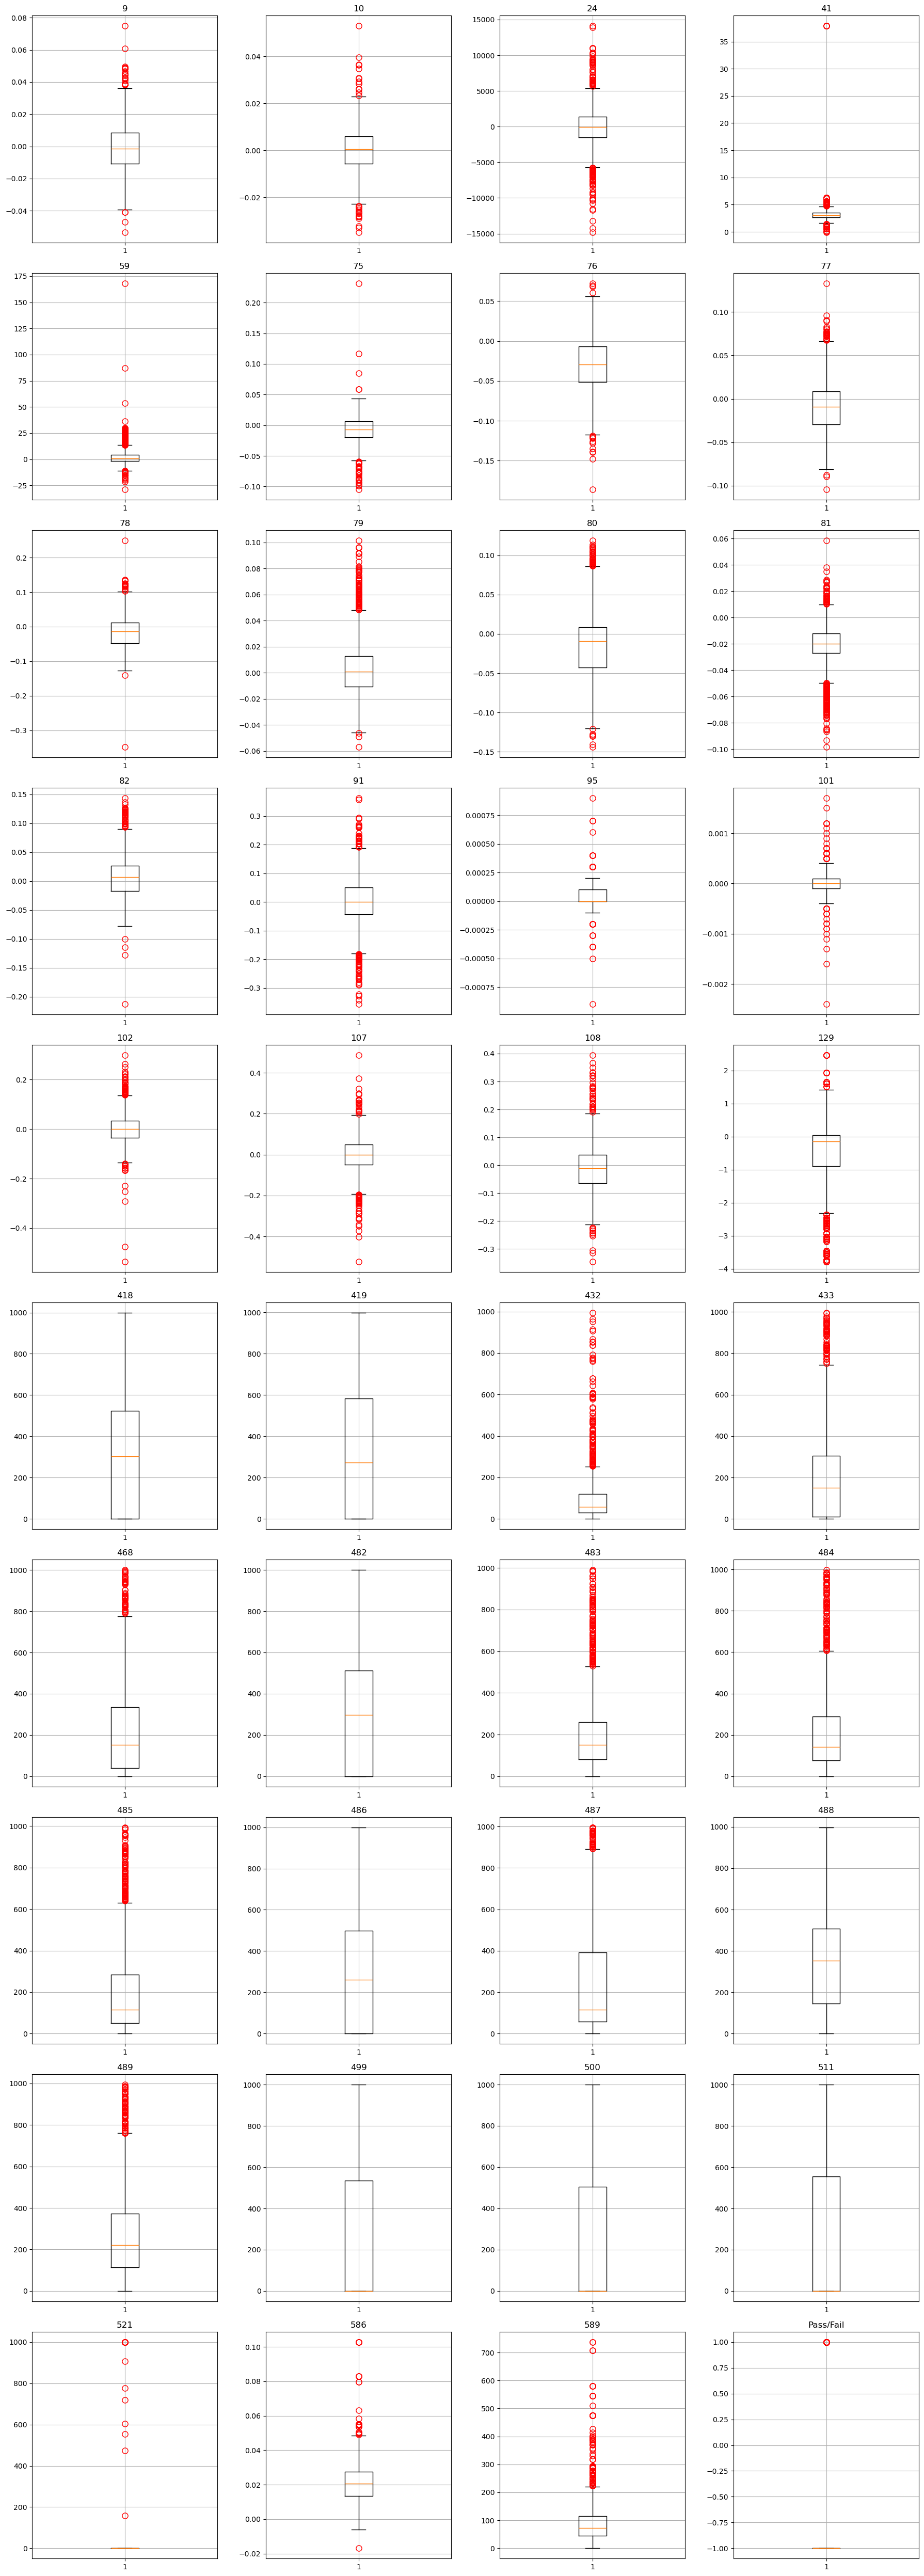

In [14]:
num_cols = df.select_dtypes(include=['float64', 'int64'])
num_features = num_cols.columns
num_features_count = len(num_features)

n_rows = (num_features_count - 1) // 4 + 1
n_cols = min(num_features_count, 4)

plt.figure(figsize=(18, 5 * n_rows))
for i, var in enumerate(num_features):
    plt.subplot(n_rows, n_cols, i + 1)
    flierprops = dict(marker='o', markeredgecolor='red', markersize=8, linestyle='none')
    plt.boxplot(df[var], whis=1.5, flierprops=flierprops)
    plt.title(var)
    plt.grid(True)
    plt.tight_layout()

plt.show()

Let's also check for the skewness in the variables.

In [15]:
cols = df.select_dtypes(include=[float, int]).columns
skew_scores = df[cols].skew()

print("Skewness Scores:")
skew_scores

Skewness Scores:


9             0.331433
10            0.057724
24           -0.054125
41           12.307135
59            4.730023
75            0.388149
76           -0.195524
77            0.594708
78            0.176220
79            1.005622
80           -0.185203
81           -0.685258
82            0.234897
91           -0.138299
95            0.127172
101          -0.276339
102          -0.206321
107          -0.280079
108           0.413221
129          -0.979244
418           0.456661
419           0.499839
432           3.346368
433           1.364392
468           1.262658
482           0.469546
483           1.714218
484           1.534042
485           1.524456
486           0.615203
487           1.160917
488           0.356705
489           1.047157
499           0.743494
500           0.920019
511           0.700040
521           9.040238
586           1.438483
589           2.715340
Pass/Fail     3.487359
dtype: float64

### Observations -

#### 1. `Distribution Plot / Histogram Observations`:

* Some features exhibit a normal distribution, suggesting they might follow a Gaussian distribution.
* Several features display significant right-skewness, indicating that their data is concentrated towards lower values with a long tail of higher values.
* A few features are left-skewed, implying that their data tends to cluster towards higher values with a long tail of lower values.
* Certain features present a bimodal distribution, suggesting the presence of two distinct clusters or modes within the data.

#### 2. `Box Plot Observations`:

* Many features contain outliers, highlighting the presence of extreme values in the dataset. These outliers may require special treatment during analysis.
* The variance or spread of values in different features varies significantly. Some features have a wide spread, indicating a high degree of variability in their data, while others have a narrower spread.

#### 3. `Skewness Score Analysis`:

* Skewness scores help quantify the direction and degree of skewness in each feature.
* Features with positive skewness scores (e.g., Feature 41, 59) are right-skewed, meaning they have a tail extending towards higher values.
* Features with negative skewness scores (e.g., Feature 24, 81) are left-skewed, indicating a tail towards lower values.
* Features with skewness scores close to zero (e.g., Feature 10, 78) are relatively normally distributed.

###  3 B - Perform bivariate and multivariate analysis with appropriate detailed comments after each analysis.

Since the number of variables in the dataset is huge, creating a pairplot would be challenging. Therefore it would be better to randomly select any 2 variables and individually performing bivariate analysis for those variables.

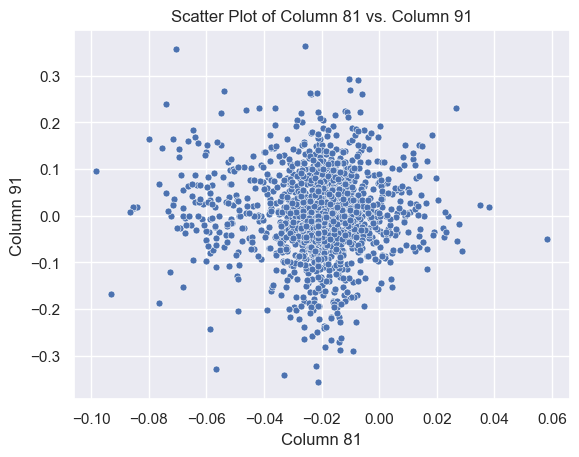

In [16]:
sns.set(style="darkgrid")

# Choosing random columns columns for the scatter 
sns.scatterplot(data=df, x='81', y='91', s=25)
plt.title(f"Scatter Plot of Column {81} vs. Column {91}")
plt.xlabel(f"Column {81}")
plt.ylabel(f"Column {91}");

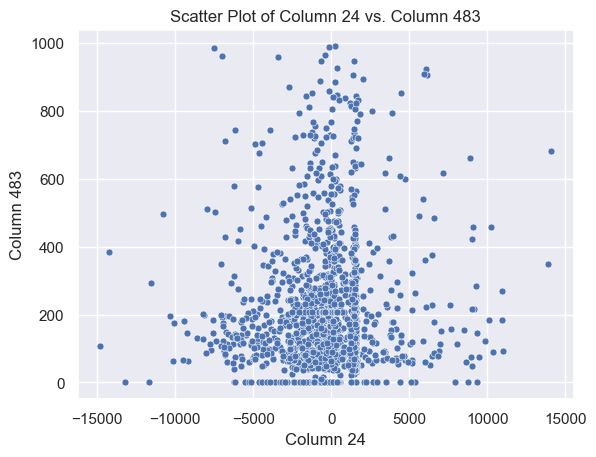

In [17]:
sns.scatterplot(data=df, x='24', y='483', s=25)
plt.title(f"Scatter Plot of Column {24} vs. Column {483}")
plt.xlabel(f"Column {24}")
plt.ylabel(f"Column {483}");

Let's now plot the heatmap of correlation matrix for all the features.

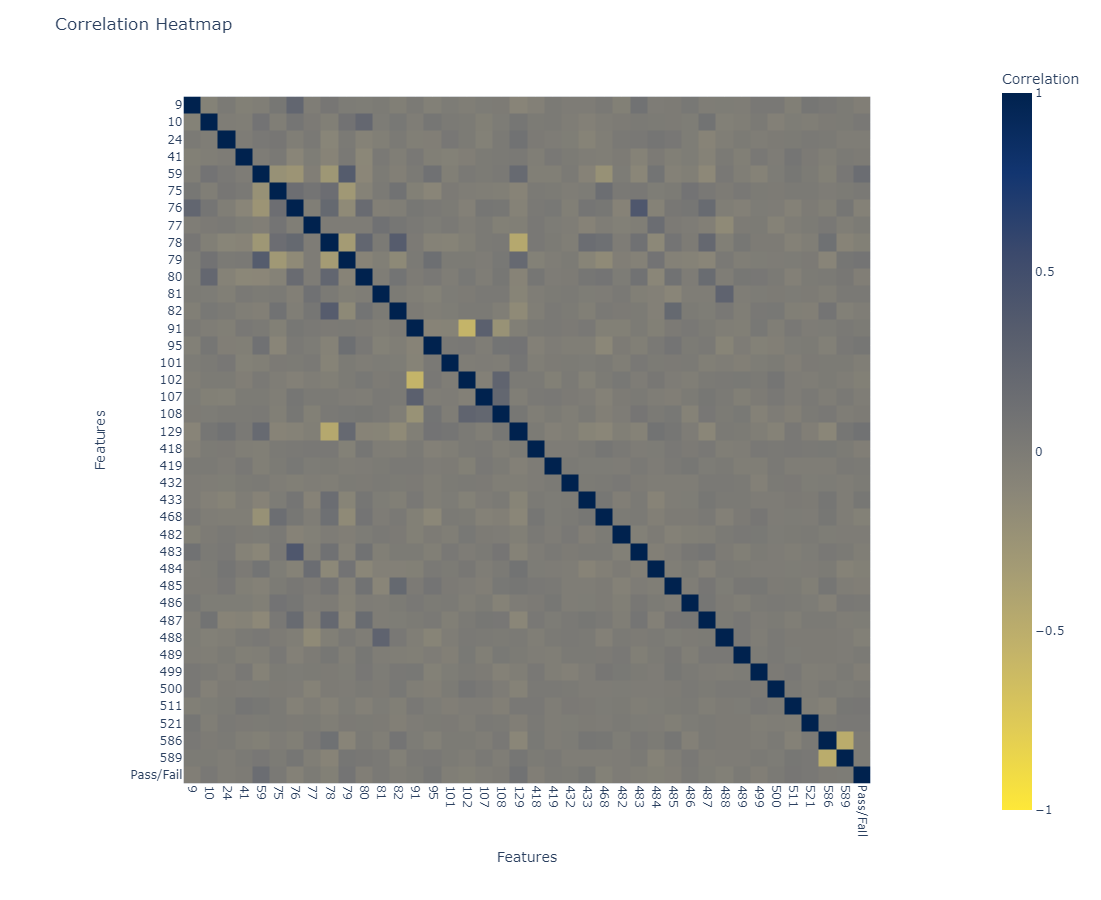

In [18]:
corr_mat = df.corr()
fig = px.imshow(corr_mat, x=corr_mat.columns, y=corr_mat.columns, 
                zmin=-1, zmax=1, color_continuous_scale=px.colors.sequential.Cividis_r, 
                labels=dict(x="Features", y="Features", color="Correlation"))
fig.update_xaxes(tickangle=90)  # Rotate x-axis labels for better readability
fig.update_layout(title="Correlation Heatmap", width=900, height=900)
fig.show()

### Observations -

1. Most of the features in the dataset exhibit a very weak positive correlation with each other.
2. Similarly, some features show a very weak negative correlation with each other.
3. `Sightly Strong Negative Correlation`: In contrast, a few pairs of features demonstrate slightly stronger negative correlations -
    * Column 78 and Column 129 have a correlation of approximately -0.45.
    * Column 91 and Column 102 show a correlation of around -0.56.
    * Column 586 and Column 589 display a correlation of approximately -0.48.

### <span style="font-family: Arial; font-weight:bold;font-size:2em;color:#556B2F;"> 4. Data Pre-processing

### 4 A - Segregate predictors vs target attributes.

In [19]:
X = df.drop(columns=['Pass/Fail'])  
y = df['Pass/Fail']

### 4 B - Check for target balancing and fix it if found imbalanced.

Let's look at the distribution of data in the target column.

In [20]:
y.value_counts()

Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64

As we can observe that the class distribution for the target variable "Pass/Fail" indicates a significant class imbalance issue. The class "-1" contains 1,463 instances, which is significantly larger than the class "1," which contains only 104 instances. Class "-1" is the majority class, while class "1" is the minority class.

#### To address this issue let's try to balance the data using Upsampling of the minority class.

In [21]:
# Separate the majority and minority classes
majority_class = df[df['Pass/Fail'] == -1]
minority_class = df[df['Pass/Fail'] == 1]

# Upsample the minority class 
minority_upsampled = resample(minority_class, 
                              replace=True,           # Sample with replacement
                              n_samples=len(majority_class),  # Match the number of majority class samples
                              random_state=1)        # Set a random seed for reproducibility

# Combine the upsampled minority class with the majority class
df_upsampled = pd.concat([majority_class, minority_upsampled])

print(df_upsampled['Pass/Fail'].value_counts())

Pass/Fail
-1    1463
 1    1463
Name: count, dtype: int64


#### Therefore the class is now balanced.

### 4 C - Perform train-test split and standardize the data or vice versa if required.

In [22]:
# Separate the features (predictors) and the target (Pass/Fail)
X = df_upsampled.drop(columns=['Pass/Fail'])
y = df_upsampled['Pass/Fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create a pipeline for data preprocessing
pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

# Scaling whole data using pipeline
X_scaled = pipeline.fit_transform(X)

# Fit the pipeline on the training data and transform it
X_train_preprocessed = pipeline.fit_transform(X_train)

# Transform the test data using the same pipeline
X_test_preprocessed = pipeline.transform(X_test)

### 4 D - Check if the train and test data have similar statistical characteristics when compared with original data.

In [23]:
original_data_summary = df.describe()
train_data_summary = pd.DataFrame(X_train_preprocessed, columns=X.columns).describe()
test_data_summary = pd.DataFrame(X_test_preprocessed, columns=X.columns).describe()

print("5-Point Summary for Original Data:")
original_data_summary

5-Point Summary for Original Data:


9           10            24           41           59  \
count  1567.000000  1567.000000   1567.000000  1567.000000  1567.000000   
mean     -0.000841     0.000146   -298.598136     3.353066     2.960241   
std       0.015107     0.009296   2900.835956     2.342268     9.510891   
min      -0.053400    -0.034900 -14804.500000    -0.075900   -28.988200   
25%      -0.010800    -0.005600  -1474.375000     2.699000    -1.855450   
50%      -0.001300     0.000400    -80.500000     3.080000     0.973600   
75%       0.008400     0.005900   1376.250000     3.515000     4.337700   
max       0.074900     0.053000  14106.000000    37.880000   168.145500   

                75           76           77           78           79  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean     -0.006903    -0.029390    -0.007041    -0.013643     0.003458   
std       0.022121     0.032948     0.031127     0.047504     0.022902   
min      -0.104900    -0.186200    -0.104600    -0.348200    -0.056800   
25%      -0.019200    -0.051350    -0.029400    -0.047300    -0.010700   
50%      -0.006600    -0.029390    -0.009400    -0.013643     0.000800   
75%       0.006600    -0.006900     0.008900     0.012050     0.012800   
max       0.231500     0.072300     0.133100     0.249200     0.101300   

                80           81           82           91           95  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean     -0.018531    -0.021153     0.006055     0.002440     0.000060   
std       0.048847     0.016890     0.035797     0.087515     0.000104   
min      -0.143700    -0.098200    -0.212900    -0.357000    -0.000900   
25%      -0.042950    -0.027100    -0.017350    -0.042650     0.000000   
50%      -0.009300    -0.019900     0.006700     0.000100     0.000000   
75%       0.008700    -0.012150     0.026800     0.050350     0.000100   
max       0.118600     0.058400     0.143700     0.362700     0.000900   

               101          102          107          108          129  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean     -0.000007     0.001115    -0.001766    -0.010789    -0.554228   
std       0.000220     0.062847     0.087307     0.086591     1.216967   
min      -0.002400    -0.535300    -0.522600    -0.345400    -3.779000   
25%      -0.000100    -0.035300    -0.048350    -0.064400    -0.898800   
50%       0.000000     0.000000     0.000000    -0.010789    -0.141900   
75%       0.000100     0.033600     0.048600     0.037850     0.047300   
max       0.001700     0.297900     0.485600     0.393800     2.458000   

               418          419          432          433          468  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean    320.259235   309.061299    99.367633   205.519304   224.173047   
std     287.520704   325.240503   126.108109   225.634649   230.250575   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000    31.033850    10.047450    38.882650   
50%     302.310800   272.891600    58.287600   151.168700   151.147200   
75%     523.624450   582.803100   120.136900   304.541800   334.674000   
max     999.316000   998.681300   994.285700   995.744700   999.877000   

               482          483          484          485          486  \
count  1567.000000  1567.000000  1567.000000  1567.000000  1567.000000   
mean    318.418448   206.564196   215.288948   201.111728   302.506186   
std     278.849666   191.380818   211.487178   217.007760   285.153545   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    82.410150    77.011800    51.188500     0.000000   
50%     298.425400   150.880100   142.526200   115.891900   260.141800   
75%     512.390750   260.079000   288.918450   283.289000   497.384500   
max     999.413500   989.473700   996.858600   994.000000   999.491100   

      

In [24]:
print("\n5-Point Summary for Training Data:")
train_data_summary


5-Point Summary for Training Data:


9            10            24            41            59  \
count  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03   
mean   1.170938e-17 -1.734723e-18  2.081668e-17 -9.887924e-17 -6.158268e-17   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -3.530319e+00 -3.678463e+00 -5.358687e+00 -1.736875e+00 -2.325672e+00   
25%   -5.935012e-01 -5.887701e-01 -4.154417e-01 -3.670108e-01 -5.962209e-01   
50%    1.576861e-02  6.223536e-02  1.448802e-01 -1.561780e-01 -2.887744e-01   
75%    5.719841e-01  5.995732e-01  6.567795e-01  1.785566e-01  3.747435e-01   
max    5.252751e+00  5.404614e+00  5.461961e+00  1.722604e+01  1.547598e+01   

                 75            76            77            78            79  \
count  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03   
mean  -8.673617e-18 -1.387779e-17  6.938894e-18  1.994932e-17 -1.561251e-17   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -4.170713e+00 -4.662621e+00 -2.951298e+00 -2.008331e+00 -2.206232e+00   
25%   -5.603198e-01 -6.275422e-01 -7.044972e-01 -8.032646e-01 -6.964454e-01   
50%    8.179228e-03 -1.258646e-02 -8.857308e-02  4.528537e-02 -1.493597e-01   
75%    5.183435e-01  6.053986e-01  5.107248e-01  5.519135e-01  5.387383e-01   
max    1.010116e+01  3.047046e+00  4.234232e+00  3.208062e+00  3.832915e+00   

                 80            81            82            91            95  \
count  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03   
mean  -2.081668e-17  1.457168e-16  2.602085e-17  1.561251e-17 -6.245005e-17   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -2.303912e+00 -4.261690e+00 -2.290440e+00 -4.347469e+00 -9.160130e+00   
25%   -1.048856e+00 -3.445613e-01 -7.780718e-01 -5.008862e-01 -6.930075e-01   
50%    2.231343e-01  6.632625e-02  4.014017e-02 -7.270548e-03  2.477839e-01   
75%    5.862913e-01  5.456951e-01  6.534507e-01  6.124012e-01  2.477839e-01   
max    2.631637e+00  3.205507e+00  3.864967e+00  4.448999e+00  5.892532e+00   

                101           102           107           108           129  \
count  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03   
mean   2.341877e-17 -1.734723e-18 -3.469447e-18 -3.469447e-18 -3.469447e-18   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -1.264075e+01 -7.762258e+00 -5.753368e+00 -3.827637e+00 -3.129238e+00   
25%   -3.927769e-01 -5.610029e-01 -5.205278e-01 -6.241555e-01 -2.404908e-01   
50%    1.397435e-01 -4.535210e-02  3.178145e-02 -1.747028e-02  3.210072e-01   
75%    6.722640e-01  4.149072e-01  5.152594e-01  5.685325e-01  5.369329e-01   
max    9.192591e+00  4.383050e+00  5.394544e+00  4.665956e+00  2.565173e+00   

                418           419           432           433           468  \
count  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03   
mean  -4.510281e-17  5.204170e-17  1.734723e-17 -3.989864e-17  5.204170e-17   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -1.082828e+00 -9.858568e-01 -8.558675e-01 -9.289719e-01 -8.765231e-01   
25%   -1.082828e+00 -9.858568e-01 -5.824800e-01 -8.854885e-01 -7.444483e-01   
50%   -9.523322e-02 -6.147523e-02 -3.390258e-01 -2.645382e-01 -3.796142e-01   
75%    6.954678e-01  7.810080e-01  1.754299e-01  3.886455e-01  3.908170e-01   
max    2.458600e+00  2.185605e+00  6.959726e+00  3.208511e+00  3.431371e+00   

                482           483           484           485           486  \
count  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03  2.048000e+03   
mean   6.591949e-17 -5.204170e-18  5.204170e-17 -1.179612e-16 -6.591949e-17   
std    1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min   -1.115927e+00 -1.159309e+00 -1.009549e+00 -8.921422e-01 -1.126791e+00   
25%   -1.115927e+00 -6.600305e-01 -6.544866e-01 -6.582618e-01 -

In [25]:
print("\n5-Point Summary for Testing Data:")
test_data_summary


5-Point Summary for Testing Data:


9          10          24          41          59          75  \
count  878.000000  878.000000  878.000000  878.000000  878.000000  878.000000   
mean     0.011883   -0.009517    0.099317   -0.038261   -0.000303    0.052637   
std      0.975162    1.008282    0.980834    0.771150    0.935635    1.251342   
min     -2.332316   -3.420127   -4.770317   -1.427120   -3.260572   -3.916161   
25%     -0.593501   -0.668854   -0.333100   -0.397861   -0.576288   -0.573047   
50%      0.036306    0.051902    0.184086   -0.153680   -0.267522    0.016664   
75%      0.602790    0.648657    0.709530    0.148580    0.354765    0.538495   
max      3.513936    4.019935    4.312451   17.226040    4.596790   10.101159   

               76          77          78          79          80          81  \
count  878.000000  878.000000  878.000000  878.000000  878.000000  878.000000   
mean    -0.017730    0.011797   -0.011617    0.003016   -0.029415    0.009629   
std      1.014106    1.016695    1.038494    1.039808    1.012723    1.018103   
min     -4.662621   -2.503902   -6.901566   -2.664257   -1.997204   -3.270081   
25%     -0.651777   -0.684092   -0.817859   -0.712349   -1.107187   -0.326756   
50%     -0.021674   -0.044740    0.030691   -0.134516    0.199614    0.027977   
75%      0.644023    0.558336    0.535234    0.588570    0.578765    0.534738   
max      3.168219    3.118767    5.553563    4.040723    2.456644    4.317643   

               82          91          95         101         102         107  \
count  878.000000  878.000000  878.000000  878.000000  878.000000  878.000000   
mean    -0.000262   -0.040366   -0.042597    0.157939   -0.012848   -0.040487   
std      1.004896    0.974024    1.093749    1.052976    1.002943    1.017414   
min     -6.076238   -4.533433   -5.396965   -6.783022   -3.642882   -5.753368   
25%     -0.642865   -0.500886   -0.693007   -0.392777   -0.598902   -0.556464   
50%      0.049897   -0.059066    0.247784    0.139744   -0.051183    0.025147   
75%      0.633936    0.561230    0.247784    0.672264    0.396322    0.510560   
max      3.301837    3.248346    7.774115    8.127550    4.383050    4.149499   

              108         129         418         419         432         433  \
count  878.000000  878.000000  878.000000  878.000000  878.000000  878.000000   
mean     0.024820    0.094906    0.002326    0.052250   -0.005600    0.001093   
std      0.997336    0.938478    1.030016    1.007015    1.027779    0.991678   
min     -3.359984   -3.129238   -1.082828   -0.985857   -0.855867   -0.928972   
25%     -0.572162   -0.154121   -1.082828   -0.985857   -0.579382   -0.886796   
50%     -0.007129    0.321007   -0.116139    0.055883   -0.332745   -0.296516   
75%      0.615355    0.580118    0.755655    0.840296    0.138627    0.480764   
max      4.167279    2.565173    2.458891    2.162867    7.649949    3.131186   

              468         482         483         484         485         486  \
count  878.000000  878.000000  878.000000  878.000000  878.000000  878.000000   
mean    -0.007622   -0.070315   -0.089581    0.028691   -0.047231    0.017630   
std      0.959827    0.945762    0.965530    1.054495    0.970193    0.957188   
min     -0.876523   -1.115927   -1.159309   -1.009549   -0.892142   -1.126791   
25%     -0.736057   -1.115927   -0.701920   -0.657893   -0.676925   -0.742091   
50%     -0.362596   -0.136446   -0.367569   -0.318413   -0.426807   -0.093945   
75%      0.338519    0.541111    0.259776    0.369845    0.208644    0.658552   
max      3.451265    2.357201    4.507382    4.045275    3.653782    2.437089   

              487         488         489         499         500         511  \
count  878.000000  878.000000  878.000000  878.000000  878.000000  878.000000   
mean    -0.063970   -0.038213    0.009620   -0.037003   -0.000416    0.013720   
std      0.969323    0.961309    0.988886    0.965498    1.000365    0.963085   
min     -0.911451   -1.274277   -1.211844 

### Observation -

1. `Mean, Median (50%), and Quartiles (25%, 75%)`: For most columns, the mean, median, and quartiles appear to be relatively close between the original data, training data, and testing data. This suggests that the central tendency of the features is preserved across the datasets.
2. `Standard Deviation (std)`: The standard deviation for each column also shows similar values between the datasets, indicating that the spread or dispersion of the data is consistent.
3. `Minimum and Maximum`: The minimum and maximum values in each column are similar across the datasets, indicating that the range of values for each feature is consistent.

Overall, based on the five-point summary, it appears that the statistical characteristics of the training data and testing data are quite similar to those of the original data. This is a positive sign as it suggests that the datasets have been split in a way that preserves the statistical properties of the original dataset.

### <span style="font-family: Arial; font-weight:bold;font-size:2em;color:#556B2F;"> 5. Model training, testing and tuning

### 5 A - Use any Supervised Learning technique to train a model.

Since the Target column `Pass/Fail` contains binary data that is '-1' for Pass and '1' for Fail, therefore we can use `LogisticRegression` as an algorithms for binary classification.

In [26]:
log_model_base = LogisticRegression(random_state=1)
log_model_base.fit(X_train_preprocessed, y_train)

# Predict on the preprocessed training and testing data
y_pred_train_base = log_model_base.predict(X_train_preprocessed)
y_pred = log_model_base.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy of Default Model:", accuracy)

Model Accuracy of Default Model: 0.7357630979498861


### 5 B - Use cross validation techniques.

Let's perform `K-Fold Cross validation` first.

In [27]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(log_model_base, X_train_preprocessed, y_train, cv=kf, scoring='accuracy')

mean_score = scores.mean()
std_dev = scores.std()
print("Mean Accuracy after KFold CV:", mean_score)
print("Standard Deviation:", std_dev)

Mean Accuracy after KFold CV: 0.7090028694404591
Standard Deviation: 0.025944943434254585


Let's now also perform `LeaveOneOutCV (LOOCV)` technique and measure the accuracy of the model.

In [28]:
loo = LeaveOneOut()

# Perform LOOCV and calculate the accuracy for each iteration
acc = cross_val_score(log_model_base, X_train_preprocessed, y_train, cv=loo, scoring='accuracy')

mean_acc = acc.mean()
std_deviation = acc.std()
print("Mean Accuracy after LOOCV:", mean_acc)
print("Standard Deviation:", std_deviation)

Mean Accuracy after LOOCV: 0.7021484375
Standard Deviation: 0.45731390665090055


Now even though the target column is balanced, still let's apply `stratifiedKFold Cross Validation` and check if it impacts the accuracy of the model.

In [29]:
stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Perform Stratified K-Fold Cross-Validation with cross_val_score
scores = cross_val_score(log_model_base, X_train_preprocessed, y_train, cv=stratified_kf, scoring='accuracy')

mean_score = scores.mean()
std_deviation = scores.std()
print("Mean Accuracy after StratifiedKFold CV:", mean_score)
print("Standard Deviation:", std_deviation)

Mean Accuracy after StratifiedKFold CV: 0.7060545193687231
Standard Deviation: 0.020924186070281653


`K-fold cross-validation`, `LOOCV`, and `stratified K-fold cross-validation` provided similar accuracy scores, indicating that the model's performance is consistent across different cross-validation methods.

### 5 C - Apply hyper-parameter tuning techniques to get the best accuracy.

### 5 E - Display and explain the classification report in detail.

Let's apply hyper-parameter tuning using `RandomizedSearchCV Technique`. 

#### `Note` :-

Since the data we are working with is huge, therefore RandomizedSearchCV would be a good choice for hyperparameter tuning over GridSearchCV due to following reasons -

* `Reduced Computation Time`: RandomizedSearchCV randomly samples a specified number of hyperparameter combinations from a given search space. This means it explores a smaller subset of the hyperparameter space compared to GridSearchCV, which exhaustively searches through all possible combinations. With a large dataset, GridSearchCV can be extremely time-consuming, while RandomizedSearchCV can provide similar or better results in a fraction of the time.
* `Better Exploration of the Hyperparameter Space`: RandomizedSearchCV provides a more efficient exploration of the hyperparameter space. Since it samples hyperparameters randomly, it's more likely to explore a diverse set of combinations, which can help you discover better hyperparameter settings.
* `Parallelization`: RandomizedSearchCV can be easily parallelized, especially when working with large datasets and complex models. You can distribute the search across multiple processors or machines to further reduce tuning time.
* `Customizable Search Space`: You can define the hyperparameter search space more flexibly in RandomizedSearchCV. This allows you to focus on the hyperparameters that matter most for your specific problem, which can be especially helpful when dealing with large datasets where searching the entire space may not be practical.
* `Resource Efficiency`: RandomizedSearchCV allows you to allocate your computational resources more efficiently. Since you can specify the maximum number of iterations or combinations to evaluate, you have better control over the computational budget.
* `Chance of Discovering Good Hyperparameters`: RandomizedSearchCV introduces an element of chance, which can be advantageous. It may stumble upon a set of hyperparameters that perform well, even if they were not explicitly defined in your search space. This element of randomness can be beneficial in finding unexpected combinations that work well for your specific dataset.
* `Scalability`: RandomizedSearchCV is scalable to larger datasets because it doesn't rely on a full grid search. It's well-suited for scenarios where you have limited computational resources or want to tune hyperparameters quickly.

In [30]:
# Define a distribution of hyperparameters to sample from
param_dist = {
    'C': uniform(0.001, 10),         # Regularization strength
    'penalty': ['l1', 'l2'],         # Penalty type
    'solver': ['liblinear', 'saga']  # Optimization solver
}

random_search = RandomizedSearchCV(estimator=log_model_base, param_distributions=param_dist, n_iter=200, cv=10, scoring='accuracy', random_state=1)

random_search.fit(X_train_preprocessed, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters (RandomizedSearch):", best_params)

# Get the best model with the optimal hyperparameters
best_log_model_rs = random_search.best_estimator_

Best Hyperparameters (RandomizedSearch): {'C': 0.029703270311589702, 'penalty': 'l2', 'solver': 'liblinear'}


In [31]:
y_pred_train_rs = best_log_model_rs.predict(X_train_preprocessed)
y_pred_test_rs = best_log_model_rs.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred_test_rs)
print("Accuracy after RandomizedSearch:", accuracy)

Accuracy after RandomizedSearch: 0.7300683371298405


### 5 D - Use any other technique/method which can enhance the model performance.
### 5 E - Display and explain the classification report in detail.

Let's try applying `Principle Component Analysis (PCA)` on the data and check if it improves/enhances the model performance. 

In [32]:
pca = PCA()
pca.fit(X_scaled)

PCA()

Let's now plot a graph to display the variance explained by each principal component.

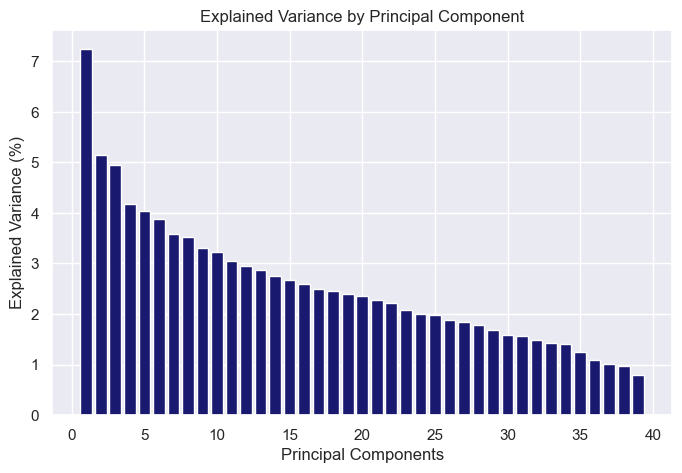

In [33]:
explained_variance = pca.explained_variance_ratio_
explained_variance_percentage = explained_variance * 100

# Plots the explained variance
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance_percentage, align='center', color='midnightblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Component')
plt.show()

Let's now find the minimum number of Components which explains 90% or above variance.

In [34]:
threshold = 0.90 
cumulative_variance = explained_variance.cumsum()

# Find the minimum number of components to achieve the threshold
min_components = next(i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold) + 1

print(f"Minimum number of components to explain {threshold * 100:.1f}% variance: {min_components}")

Minimum number of components to explain 90.0% variance: 31


##### Since we got the minimum number of components required, so lets train the tuned model on PCA-transformed data using pipeline.

In [35]:
log_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('log_reg', best_log_model_rs) # RandomizedSearch tuned model with optimal parameters
]) 

X_train_pca = log_pipeline.fit(X_train_preprocessed, y_train) 
X_test_pca = log_pipeline.fit(X_test_preprocessed, y_test)

# Predict on the test data using the transformed features
y_pred_train_pca = log_pipeline.predict(X_train_preprocessed)
y_pred_test_pca = log_pipeline.predict(X_test_preprocessed)

train_pca_score = log_pipeline.score(X_train_preprocessed, y_train)
test_pca_score = log_pipeline.score(X_test_preprocessed, y_test)

print('Train Accuracy:', train_pca_score)
print('Test Accuracy:', test_pca_score)
print()
report = classification_report(y_test, y_pred_test_pca)
print("Classification Report:\n")
print(report)

Train Accuracy: 0.693359375
Test Accuracy: 0.7323462414578588

Classification Report:

              precision    recall  f1-score   support

          -1       0.75      0.70      0.73       444
           1       0.71      0.76      0.74       434

    accuracy                           0.73       878
   macro avg       0.73      0.73      0.73       878
weighted avg       0.73      0.73      0.73       878



### Classification Report Analysis -

* `Accuracy`: The model achieved an accuracy of approximately 73.23%, which means it correctly classified about 73.23% of the samples.

* `Precision`:

    * Precision for class -1 (Pass): 0.75. This means that when the model predicts a sample as "Pass" (-1), it is correct 75% of the time.
    * Precision for class 1 (Fail): 0.71 which means when the model predicts a sample as "Fail" (1), it is correct 71% of the time.
    
* `Recall (Sensitivity)`:
    * Recall for class -1 (Pass): 0.70. The model correctly identifies 70% of the actual "Pass" samples.
    * Recall for class 1 (Fail): 0.76. The model correctly identifies 76% of the actual "Fail" samples..
    
* `F1-Score`:
    * F1-score for class -1 (Pass): 0.73, which is the harmonic mean of precision and recall, providing a balanced measure of both precision and recall for class "-1."
    * F1-score for class 1 (Fail): Similarly, the F1-score for class "1" is 0.74.

    
* `Support`: The "support" column shows the number of samples in each class:
    * Class -1 (Pass) has 444 samples.
    * Class 1 (Fail) has 434 samples.

* `Macro Avg`:
    * Macro Precision: The macro average precision is 0.73. It is the average of the precision scores for both classes (Pass and Fail), treating both classes equally.
    * Macro Recall: The macro average recall is also 0.73. It is the average of the recall scores for both classes, providing equal weight to each class.
    * Macro F1-Score: The macro average F1-score is 0.73. It is the average of the F1-scores for both classes, giving equal importance to both precision and recall.
* `Weighted Avg`:
    * Weighted Precision: The weighted average precision is 0.73. It takes into account the number of samples in each class and gives more weight to the class with more samples.
    * Weighted Recall: The weighted average recall is also 0.73. It considers class imbalances and gives more weight to the class with more samples when calculating recall.
    * Weighted F1-Score: The weighted average F1-score is 0.73. It combines precision and recall while giving more weight to the class with more samples. This metric is useful when dealing with class imbalances.

PCA reduced the number of features to 31 components, which explained 90% or more of the variance. While the accuracy decreased very slightly compared to base model after PCA, the reduction in dimensionality can help with model interpretability and training efficiency. However, there's a trade-off between dimensionality reduction and accuracy.

### 5 F - Apply the above steps for all possible models that you have learnt so far.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 1. Naïve Bayes 

Let's first train the default model.

In [36]:
nb_default = GaussianNB()
nb_default.fit(X_train_preprocessed, y_train)

# Make predictions on both training and test data
train_pred_nb_def = nb_default.predict(X_train_preprocessed)
test_pred_nb_def = nb_default.predict(X_test_preprocessed)

#### Let's now perform RandomizedSearchCV for same.

In [37]:
param_dist = {
    'var_smoothing': uniform(1e-9, 1e-3)
}

random_search = RandomizedSearchCV(estimator=nb_default, param_distributions=param_dist, n_iter=200, cv=10, scoring='accuracy', random_state=1)

random_search.fit(X_train_preprocessed, y_train)
best_params_random = random_search.best_params_
print("Best Parameters (RandomizedSearch):", best_params_random)

best_model_nb_random = random_search.best_estimator_

# Make predictions on both training and test data using the best model
train_pred_nb_random = best_model_nb_random.predict(X_train_preprocessed)
test_pred_nb_random = best_model_nb_random.predict(X_test_preprocessed)

Best Parameters (RandomizedSearch): {'var_smoothing': 0.00041702300470257403}


<span style="font-family: Arial; font-weight:bold;font-size:1em;color:#228B22;"> `Note`:  When we perform hyperparameter tuning using RandomizedSearchCV (or any other hyperparameter search method), we are already conducting cross-validation as part of the tuning process. RandomizedSearchCV internally performs k-fold cross-validation to evaluate different hyperparameter combinations and estimate their performance. Therefore, there's no need to perform any Cross-Validation Techniques separately.

#### Now let's train the Tuned Model using processed PCA data.

In [38]:
nb_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('nb_pca', best_model_nb_random) # RandomizedSearch tuned model with optimal parameters
]) 

X_train_pca = nb_pipeline.fit(X_train_preprocessed, y_train) 
X_test_pca = nb_pipeline.fit(X_test_preprocessed, y_test)

# Predict on the test data using the transformed features
train_pred_nb_pca = nb_pipeline.predict(X_train_preprocessed)
test_pred_nb_pca = nb_pipeline.predict(X_test_preprocessed)

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 2. Support Vector Classifier (SVC)

#### Default Model -

In [39]:
svc_default = SVC(random_state=1)
svc_default.fit(X_train_preprocessed, y_train)

train_pred_svc_def = svc_default.predict(X_train_preprocessed)
test_pred_svc_def = svc_default.predict(X_test_preprocessed)

#### Hyper-parameters tuning using RandomizedSearchCV -

In [40]:
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': randint(2, 5),
    'gamma': uniform(0.1, 10)
}

random_search = RandomizedSearchCV(estimator=svc_default, param_distributions=param_dist, n_iter=200, cv=10, scoring='accuracy', random_state=1)
random_search.fit(X_train_preprocessed, y_train)

best_params_svc_random = random_search.best_params_
print("Best Parameters (RandomizedSearch):", best_params_svc_random)
best_model_svc_random = random_search.best_estimator_

train_pred_svc_random = best_model_svc_random.predict(X_train_preprocessed)
test_pred_svc_random = best_model_svc_random.predict(X_test_preprocessed)

Best Parameters (RandomizedSearch): {'C': 4.27022004702574, 'degree': 2, 'gamma': 9.425573593386588, 'kernel': 'rbf'}


#### Now let's train the Tuned Model using processed PCA data.

In [41]:
svc_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('svc_pca', best_model_svc_random) 
]) 

X_train_pca = svc_pipeline.fit(X_train_preprocessed, y_train) 
X_test_pca = svc_pipeline.fit(X_test_preprocessed, y_test)

train_pred_svc_pca = nb_pipeline.predict(X_train_preprocessed)
test_pred_svc_pca = nb_pipeline.predict(X_test_preprocessed)

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 3. DecisionTree Classifier

#### Default Model -

In [42]:
dt_default = DecisionTreeClassifier(random_state=1)
dt_default.fit(X_train_preprocessed, y_train)

train_pred_dt_default = dt_default.predict(X_train_preprocessed)
test_pred_dt_default = dt_default.predict(X_test_preprocessed)

#### Hyper-parameters tuning using RandomizedSearchCV -

In [43]:
param_dist = {
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(2, 40),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(2, 7),
}

random_search = RandomizedSearchCV(estimator=dt_default, param_distributions=param_dist, n_iter=200, cv=10, scoring='accuracy', random_state=1)
random_search.fit(X_train_preprocessed, y_train)

best_params_dt_random = random_search.best_params_
print("Best Parameters (RandomizedSearch):", best_params_dt_random)
best_model_dt_random = random_search.best_estimator_

train_pred_dt_rs = best_model_dt_random.predict(X_train_preprocessed)
test_pred_dt_rs = best_model_dt_random.predict(X_test_preprocessed)

Best Parameters (RandomizedSearch): {'criterion': 'entropy', 'max_depth': 27, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}


#### DecisionTree model on the PCA-processed data -

In [44]:
dt_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('dt_pca', best_model_dt_random) 
]) 

X_train_pca = dt_pipeline.fit(X_train_preprocessed, y_train) 
X_test_pca = dt_pipeline.fit(X_test_preprocessed, y_test)

train_pred_dt_pca = dt_pipeline.predict(X_train_preprocessed)
test_pred_dt_pca = dt_pipeline.predict(X_test_preprocessed)

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 4. RandomForest Classifier

#### Default Model -

In [45]:
rf_default = RandomForestClassifier(random_state=1)
rf_default.fit(X_train_preprocessed, y_train)

train_pred_rf_default = rf_default.predict(X_train_preprocessed)
test_pred_rf_default = rf_default.predict(X_test_preprocessed)

#### Hyper-parameters tuning using RandomizedSearchCV -

In [46]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': list(range(1,50,5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 4]
}

random_search_rf = RandomizedSearchCV(estimator=rf_default, param_distributions=param_dist, n_iter=200, cv=10, scoring='accuracy', random_state=1)
random_search_rf.fit(X_train_preprocessed, y_train)

best_params_rf_random = random_search_rf.best_params_
print("Best Parameters (RandomizedSearch):", best_params_rf_random)
best_model_rf_random = random_search_rf.best_estimator_

train_pred_rf_rs = best_model_rf_random.predict(X_train_preprocessed)
test_pred_rf_rs = best_model_rf_random.predict(X_test_preprocessed)

Best Parameters (RandomizedSearch): {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 31}


#### RandomForest model on the PCA-processed data -

In [47]:
rf_pipeline = Pipeline([
    ('pca', PCA(n_components=min_components)),
    ('rf_pca', best_model_rf_random)
]) 

X_train_pca = rf_pipeline.fit(X_train_preprocessed, y_train) 
X_test_pca = rf_pipeline.fit(X_test_preprocessed, y_test)

train_pred_rf_pca = rf_pipeline.predict(X_train_preprocessed)
test_pred_rf_pca = rf_pipeline.predict(X_test_preprocessed)

### <span style="font-family: Arial; font-weight:bold;font-size:2em;color:#556B2F;"> 6. Post Training and Conclusion

### 6 A- Display and compare all the models designed with their train and test accuracies.

Now that we have trained different model, let's first calculate the train and test performance metrics for each algorithm individually so that it's easy to compare the models.

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 1. Logistic Regression

In [48]:
# Calculate TRAIN metrics for the base model
train_accuracy_base = accuracy_score(y_train, y_pred_train_base)
train_precision_base = precision_score(y_train, y_pred_train_base)
train_recall_base = recall_score(y_train, y_pred_train_base)
train_f1_base = f1_score(y_train, y_pred_train_base)

# Calculate TEST metrics for the base model
test_accuracy_base = accuracy_score(y_test, y_pred)
test_precision_base = precision_score(y_test, y_pred)
test_recall_base = recall_score(y_test, y_pred)
test_f1_base = f1_score(y_test, y_pred)

# Calculate TRAIN metrics for the tuned model
train_accuracy_rs = accuracy_score(y_train, y_pred_train_rs)
train_precision_rs = precision_score(y_train, y_pred_train_rs)
train_recall_rs = recall_score(y_train, y_pred_train_rs)
train_f1_rs = f1_score(y_train, y_pred_train_rs)

# Calculate TEST metrics for the tuned model
test_accuracy_rs = accuracy_score(y_test, y_pred_test_rs)
test_precision_rs = precision_score(y_test, y_pred_test_rs)
test_recall_rs = recall_score(y_test, y_pred_test_rs)
test_f1_rs = f1_score(y_test, y_pred_test_rs)

# Calculate TRAIN metrics for the PCA-transformed tuned model
train_accuracy_pca = accuracy_score(y_train, y_pred_train_pca)
train_precision_pca = precision_score(y_train, y_pred_train_pca)
train_recall_pca = recall_score(y_train, y_pred_train_pca)
train_f1_pca = f1_score(y_train, y_pred_train_pca)

# Calculate TEST metrics for the PCA-transformed tuned model
test_accuracy_pca = accuracy_score(y_test, y_pred_test_pca)
test_precision_pca = precision_score(y_test, y_pred_test_pca)
test_recall_pca = recall_score(y_test, y_pred_test_pca)
test_f1_pca = f1_score(y_test, y_pred_test_pca)

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 2. Naïve Bayes 

In [49]:
# Calculate TRAIN metrics for the Gaussian Naive Bayes base model
train_accuracy_nb_def = accuracy_score(y_train, train_pred_nb_def)
train_precision_nb_def = precision_score(y_train, train_pred_nb_def)
train_recall_nb_def = recall_score(y_train, train_pred_nb_def)
train_f1_nb_def = f1_score(y_train, train_pred_nb_def)

# Calculate TEST metrics for the Gaussian Naive Bayes base model
test_accuracy_nb_def = accuracy_score(y_test, test_pred_nb_def)
test_precision_nb_def = precision_score(y_test, test_pred_nb_def)
test_recall_nb_def = recall_score(y_test, test_pred_nb_def)
test_f1_nb_def = f1_score(y_test, test_pred_nb_def)

# Calculate TRAIN metrics for the tuned Gaussian Naive Bayes model
train_accuracy_nb_random = accuracy_score(y_train, train_pred_nb_random)
train_precision_nb_random = precision_score(y_train, train_pred_nb_random)
train_recall_nb_random = recall_score(y_train, train_pred_nb_random)
train_f1_nb_random = f1_score(y_train, train_pred_nb_random)

# Calculate TEST metrics for the tuned Gaussian Naive Bayes model
test_accuracy_nb_random = accuracy_score(y_test, test_pred_nb_random)
test_precision_nb_random = precision_score(y_test, test_pred_nb_random)
test_recall_nb_random = recall_score(y_test, test_pred_nb_random)
test_f1_nb_random = f1_score(y_test, test_pred_nb_random)

# Calculate TRAIN metrics for the PCA-transformed tuned Gaussian Naive Bayes model
train_accuracy_nb_pca = accuracy_score(y_train, train_pred_nb_pca)
train_precision_nb_pca = precision_score(y_train, train_pred_nb_pca)
train_recall_nb_pca = recall_score(y_train, train_pred_nb_pca)
train_f1_nb_pca = f1_score(y_train, train_pred_nb_pca)

# Calculate TEST metrics for the PCA-transformed tuned Gaussian Naive Bayes model
test_accuracy_nb_pca = accuracy_score(y_test, test_pred_nb_pca)
test_precision_nb_pca = precision_score(y_test, test_pred_nb_pca)
test_recall_nb_pca = recall_score(y_test, test_pred_nb_pca)
test_f1_nb_pca = f1_score(y_test, test_pred_nb_pca)

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 3. Support Vector Classifier (SVC)

In [50]:
# Calculate TRAIN metrics for the default SVC model
train_accuracy_svc_def = accuracy_score(y_train, train_pred_svc_def)
train_precision_svc_def = precision_score(y_train, train_pred_svc_def)
train_recall_svc_def = recall_score(y_train, train_pred_svc_def)
train_f1_svc_def = f1_score(y_train, train_pred_svc_def)

# Calculate TEST metrics for the default SVC model
test_accuracy_svc_def = accuracy_score(y_test, test_pred_svc_def)
test_precision_svc_def = precision_score(y_test, test_pred_svc_def)
test_recall_svc_def = recall_score(y_test, test_pred_svc_def)
test_f1_svc_def = f1_score(y_test, test_pred_svc_def)

# Calculate TRAIN metrics for the tuned SVC model
train_accuracy_svc_random = accuracy_score(y_train, train_pred_svc_random)
train_precision_svc_random = precision_score(y_train, train_pred_svc_random)
train_recall_svc_random = recall_score(y_train, train_pred_svc_random)
train_f1_svc_random = f1_score(y_train, train_pred_svc_random)

# Calculate TEST metrics for the tuned SVC model
test_accuracy_svc_random = accuracy_score(y_test, test_pred_svc_random)
test_precision_svc_random = precision_score(y_test, test_pred_svc_random)
test_recall_svc_random = recall_score(y_test, test_pred_svc_random)
test_f1_svc_random = f1_score(y_test, test_pred_svc_random)

# Calculate TRAIN metrics for the PCA-transformed tuned SVC model
train_accuracy_svc_pca = accuracy_score(y_train, train_pred_svc_pca)
train_precision_svc_pca = precision_score(y_train, train_pred_svc_pca)
train_recall_svc_pca = recall_score(y_train, train_pred_svc_pca)
train_f1_svc_pca = f1_score(y_train, train_pred_svc_pca)

# Calculate TEST metrics for the PCA-transformed tuned SVC model
test_accuracy_svc_pca = accuracy_score(y_test, test_pred_svc_pca)
test_precision_svc_pca = precision_score(y_test, test_pred_svc_pca)
test_recall_svc_pca = recall_score(y_test, test_pred_svc_pca)
test_f1_svc_pca = f1_score(y_test, test_pred_svc_pca)

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 4. DecisionTree Classifier

In [51]:
# Calculate TRAIN metrics for the default Decision Tree Classifier model
train_accuracy_dt_default = accuracy_score(y_train, train_pred_dt_default)
train_precision_dt_default = precision_score(y_train, train_pred_dt_default)
train_recall_dt_default = recall_score(y_train, train_pred_dt_default)
train_f1_dt_default = f1_score(y_train, train_pred_dt_default)

# Calculate TEST metrics for the default Decision Tree Classifier model
test_accuracy_dt_default = accuracy_score(y_test, test_pred_dt_default)
test_precision_dt_default = precision_score(y_test, test_pred_dt_default)
test_recall_dt_default = recall_score(y_test, test_pred_dt_default)
test_f1_dt_default = f1_score(y_test, test_pred_dt_default)

# Calculate TRAIN metrics for the tuned Decision Tree Classifier model
train_accuracy_dt_rs = accuracy_score(y_train, train_pred_dt_rs)
train_precision_dt_rs = precision_score(y_train, train_pred_dt_rs)
train_recall_dt_rs = recall_score(y_train, train_pred_dt_rs)
train_f1_dt_rs = f1_score(y_train, train_pred_dt_rs)

# Calculate TEST metrics for the tuned Decision Tree Classifier model
test_accuracy_dt_rs = accuracy_score(y_test, test_pred_dt_rs)
test_precision_dt_rs = precision_score(y_test, test_pred_dt_rs)
test_recall_dt_rs = recall_score(y_test, test_pred_dt_rs)
test_f1_dt_rs = f1_score(y_test, test_pred_dt_rs)

# Calculate TRAIN metrics for the PCA-transformed tuned Decision Tree Classifier model
train_accuracy_dt_pca = accuracy_score(y_train, train_pred_dt_pca)
train_precision_dt_pca = precision_score(y_train, train_pred_dt_pca)
train_recall_dt_pca = recall_score(y_train, train_pred_dt_pca)
train_f1_dt_pca = f1_score(y_train, train_pred_dt_pca)

# Calculate TEST metrics for the PCA-transformed tuned Decision Tree Classifier model
test_accuracy_dt_pca = accuracy_score(y_test, test_pred_dt_pca)
test_precision_dt_pca = precision_score(y_test, test_pred_dt_pca)
test_recall_dt_pca = recall_score(y_test, test_pred_dt_pca)
test_f1_dt_pca = f1_score(y_test, test_pred_dt_pca)

#### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#FD5E53;"> 5. RandomForest Classifier

In [52]:
# Calculate TRAIN metrics for the default Random Forest Classifier model
train_accuracy_rf_default = accuracy_score(y_train, train_pred_rf_default)
train_precision_rf_default = precision_score(y_train, train_pred_rf_default)
train_recall_rf_default = recall_score(y_train, train_pred_rf_default)
train_f1_rf_default = f1_score(y_train, train_pred_rf_default)

# Calculate TEST metrics for the default Random Forest Classifier model
test_accuracy_rf_default = accuracy_score(y_test, test_pred_rf_default)
test_precision_rf_default = precision_score(y_test, test_pred_rf_default)
test_recall_rf_default = recall_score(y_test, test_pred_rf_default)
test_f1_rf_default = f1_score(y_test, test_pred_rf_default)

# Calculate TRAIN metrics for the tuned Random Forest Classifier model
train_accuracy_rf_rs = accuracy_score(y_train, train_pred_rf_rs)
train_precision_rf_rs = precision_score(y_train, train_pred_rf_rs)
train_recall_rf_rs = recall_score(y_train, train_pred_rf_rs)
train_f1_rf_rs = f1_score(y_train, train_pred_rf_rs)

# Calculate TEST metrics for the tuned Random Forest Classifier model
test_accuracy_rf_rs = accuracy_score(y_test, test_pred_rf_rs)
test_precision_rf_rs = precision_score(y_test, test_pred_rf_rs)
test_recall_rf_rs = recall_score(y_test, test_pred_rf_rs)
test_f1_rf_rs = f1_score(y_test, test_pred_rf_rs)

# Calculate TRAIN metrics for the PCA-transformed tuned Random Forest Classifier model
train_accuracy_rf_pca = accuracy_score(y_train, train_pred_rf_pca)
train_precision_rf_pca = precision_score(y_train, train_pred_rf_pca)
train_recall_rf_pca = recall_score(y_train, train_pred_rf_pca)
train_f1_rf_pca = f1_score(y_train, train_pred_rf_pca)

# Calculate TEST metrics for the PCA-transformed tuned Random Forest Classifier model
test_accuracy_rf_pca = accuracy_score(y_test, test_pred_rf_pca)
test_precision_rf_pca = precision_score(y_test, test_pred_rf_pca)
test_recall_rf_pca = recall_score(y_test, test_pred_rf_pca)
test_f1_rf_pca = f1_score(y_test, test_pred_rf_pca)

Now that we have claculated the performance metrics of each model, let's compare each model by creating a dataframe in which each row would represent a model and each column would represent their respective train and test performance metrics.  

In [53]:
# Create a list of dictionaries for each model's metrics
model_metrics = [
    {
        "Model": "Logistic Regression (Base)",
        "Train Accuracy": train_accuracy_base,
        "Test Accuracy": test_accuracy_base,
        "Train Precision": train_precision_base,
        "Test Precision": test_precision_base,
        "Train Recall": train_recall_base,
        "Test Recall": test_recall_base,
        "Train F1": train_f1_base,
        "Test F1": test_f1_base,
    },
    {
        "Model": "Logistic Regression (Tuned)",
        "Train Accuracy": train_accuracy_rf_rs,
        "Test Accuracy": test_accuracy_rf_rs,
        "Train Precision": train_precision_rf_rs,
        "Test Precision": test_precision_rf_rs,
        "Train Recall": train_recall_rf_rs,
        "Test Recall": test_recall_rf_rs,
        "Train F1": train_f1_rf_rs,
        "Test F1": test_f1_rf_rs,
    },
    {
        "Model": "PCA + Logistic Regression (Tuned)",
        "Train Accuracy": train_accuracy_rf_pca,
        "Test Accuracy": test_accuracy_rf_pca,
        "Train Precision": train_precision_rf_pca,
        "Test Precision": test_precision_rf_pca,
        "Train Recall": train_recall_rf_pca,
        "Test Recall": test_recall_rf_pca,
        "Train F1": train_f1_rf_pca,
        "Test F1": test_f1_rf_pca,
    },
    {
        "Model": "Naive Bayes (Default)",
        "Train Accuracy": train_accuracy_nb_def,
        "Test Accuracy": test_accuracy_nb_def,
        "Train Precision": train_precision_nb_def,
        "Test Precision": test_precision_nb_def,
        "Train Recall": train_recall_nb_def,
        "Test Recall": test_recall_nb_def,
        "Train F1": train_f1_nb_def,
        "Test F1": test_f1_nb_def,
    },
    {
        "Model": "Naive Bayes (Tuned)",
        "Train Accuracy": train_accuracy_nb_random,
        "Test Accuracy": test_accuracy_nb_random,
        "Train Precision": train_precision_nb_random,
        "Test Precision": test_precision_nb_random,
        "Train Recall": train_recall_nb_random,
        "Test Recall": test_recall_nb_random,
        "Train F1": train_f1_nb_random,
        "Test F1": test_f1_nb_random,
    },
    {
        "Model": "PCA + Naive Bayes (Tuned)",
        "Train Accuracy": train_accuracy_nb_pca,
        "Test Accuracy": test_accuracy_nb_pca,
        "Train Precision": train_precision_nb_pca,
        "Test Precision": test_precision_nb_pca,
        "Train Recall": train_recall_nb_pca,
        "Test Recall": test_recall_nb_pca,
        "Train F1": train_f1_nb_pca,
        "Test F1": test_f1_nb_pca,
    },
    {
        "Model": "Support Vector Classifier (Default)",
        "Train Accuracy": train_accuracy_svc_def,
        "Test Accuracy": test_accuracy_svc_def,
        "Train Precision": train_precision_svc_def,
        "Test Precision": test_precision_svc_def,
        "Train Recall": train_recall_svc_def,
        "Test Recall": test_recall_svc_def,
        "Train F1": train_f1_svc_def,
        "Test F1": test_f1_svc_def,
    },
    {
        "Model": "Support Vector Classifier (Tuned)",
        "Train Accuracy": train_accuracy_svc_random,
        "Test Accuracy": test_accuracy_svc_random,
        "Train Precision": train_precision_svc_random,
        "Test Precision": test_precision_svc_random,
        "Train Recall": train_recall_svc_random,
        "Test Recall": test_recall_svc_random,
        "Train F1": train_f1_svc_random,
        "Test F1": test_f1_svc_random,
    },
    {
        "Model": "PCA + Support Vector Classifier (Tuned)",
        "Train Accuracy": train_accuracy_svc_pca,
        "Test Accuracy": test_accuracy_svc_pca,
        "Train Precision": train_precision_svc_pca,
        "Test Precision": test_precision_svc_pca,
        "Train Recall": train_recall_svc_pca,
        "Test Recall": test_recall_svc_pca,
        "Train F1": train_f1_svc_pca,
        "Test F1": test_f1_svc_pca,
    },
    {
        "Model": "Decision Tree (Default)",
        "Train Accuracy": train_accuracy_dt_default,
        "Test Accuracy": test_accuracy_dt_default,
        "Train Precision": train_precision_dt_default,
        "Test Precision": test_precision_dt_default,
        "Train Recall": train_recall_dt_default,
        "Test Recall": test_recall_dt_default,
        "Train F1": train_f1_dt_default,
        "Test F1": test_f1_dt_default,
    },
    {
        "Model": "Decision Tree (Tuned)",
        "Train Accuracy": train_accuracy_dt_rs,
        "Test Accuracy": test_accuracy_dt_rs,
        "Train Precision": train_precision_dt_rs,
        "Test Precision": test_precision_dt_rs,
        "Train Recall": train_recall_dt_rs,
        "Test Recall": test_recall_dt_rs,
        "Train F1": train_f1_dt_rs,
        "Test F1": test_f1_dt_rs,
    },
    {
        "Model": "PCA + Decision Tree (Tuned)",
        "Train Accuracy": train_accuracy_dt_pca,
        "Test Accuracy": test_accuracy_dt_pca,
        "Train Precision": train_precision_dt_pca,
        "Test Precision": test_precision_dt_pca,
        "Train Recall": train_recall_dt_pca,
        "Test Recall": test_recall_dt_pca,
        "Train F1": train_f1_dt_pca,
        "Test F1": test_f1_dt_pca,
    },
    {
        "Model": "Random Forest (Default)",
        "Train Accuracy": train_accuracy_rf_default,
        "Test Accuracy": test_accuracy_rf_default,
        "Train Precision": train_precision_rf_default,
        "Test Precision": test_precision_rf_default,
        "Train Recall": train_recall_rf_default,
        "Test Recall": test_recall_rf_default,
        "Train F1": train_f1_rf_default,
        "Test F1": test_f1_rf_default,
    },
    {
        "Model": "Random Forest (Tuned)",
        "Train Accuracy": train_accuracy_rf_rs,
        "Test Accuracy": test_accuracy_rf_rs,
        "Train Precision": train_precision_rf_rs,
        "Test Precision": test_precision_rf_rs,
        "Train Recall": train_recall_rf_rs,
        "Test Recall": test_recall_rf_rs,
        "Train F1": train_f1_rf_rs,
        "Test F1": test_f1_rf_rs,
    },
    {
        "Model": "PCA + Random Forest (Tuned)",
        "Train Accuracy": train_accuracy_rf_pca,
        "Test Accuracy": test_accuracy_rf_pca,
        "Train Precision": train_precision_rf_pca,
        "Test Precision": test_precision_rf_pca,
        "Train Recall": train_recall_rf_pca,
        "Test Recall": test_recall_rf_pca,
        "Train F1": train_f1_rf_pca,
        "Test F1": test_f1_rf_pca,
    },
]
metrics_df = pd.DataFrame(model_metrics)
metrics_df

Model  Train Accuracy  Test Accuracy  \
0                Logistic Regression (Base)        0.729492       0.735763   
1               Logistic Regression (Tuned)        1.000000       0.998861   
2         PCA + Logistic Regression (Tuned)        0.985352       1.000000   
3                     Naive Bayes (Default)        0.682617       0.685649   
4                       Naive Bayes (Tuned)        0.682617       0.685649   
5                 PCA + Naive Bayes (Tuned)        0.761230       0.781321   
6       Support Vector Classifier (Default)        0.993652       0.971526   
7         Support Vector Classifier (Tuned)        1.000000       1.000000   
8   PCA + Support Vector Classifier (Tuned)        0.761230       0.781321   
9                   Decision Tree (Default)        1.000000       0.962415   
10                    Decision Tree (Tuned)        0.994629       0.956720   
11              PCA + Decision Tree (Tuned)        0.867188       0.974943   
12                  Random Forest (Default)        1.000000       0.998861   
13                    Random Forest (Tuned)        1.000000       0.998861   
14              PCA + Random Forest (Tuned)        0.985352       1.000000   

    Train Precision  Test Precision  Train Recall  Test Recall  Train F1  \
0          0.719298        0.713983      0.757046     0.776498  0.737689   
1          1.000000        0.997701      1.000000     1.000000  1.000000   
2          0.987317        1.000000      0.983479     1.000000  0.985394   
3          0.652209        0.643636      0.789116     0.815668  0.714160   
4          0.652209        0.643636      0.789116     0.815668  0.714160   
5          0.779503        0.755274      0.731778     0.824885  0.754887   
6          0.987524        0.945534      1.000000     1.000000  0.993723   
7          1.000000        1.000000      1.000000     1.000000  1.000000   
8          0.779503        0.755274      0.731778     0.824885  0.754887   
9          1.000000        0.929336      1.000000     1.000000  1.000000   
10         0.989423        0.919492      1.000000     1.000000  0.994683   
11         0.832894        0.966063      0.920311     0.983871  0.874423   
12         1.000000        0.997701      1.000000     1.000000  1.000000   
13         1.000000        0.997701      1.000000     1.000000  1.000000   
14         0.987317        1.000000      0.983479     1.000000  0.985394   

     Test F1  
0   0.743929  
1   0.998849  
2   1.000000  
3   0.719512  
4   0.719512  
5   0.788546  
6   0.972004  
7   1.000000  
8   0.788546  
9   0.963374  
10  0.958057  
11  0.974886  
12  0.998849  
13  0.998849  
14  1.000000

### 6 B - Select the final best trained model along with your detailed comments for selecting this model.

The Support Vector Classifier (SVC) in its default form is selected as the best model for several compelling reasons:

1. `High Test Accuracy`: The default SVC achieves an outstanding test accuracy of 97.15%, indicating its strong predictive power. This high accuracy level suggests that the model can effectively distinguish between different classes in the dataset, which is a critical factor for any classification task.
2. `Generalization`: The default SVC achieves this high accuracy without extensive hyperparameter tuning or dimensionality reduction techniques like PCA. This demonstrates its strong potential for generalization to real-world scenarios. Models that perform exceptionally well on the test set without overfitting are valuable in practice.
3. `Robustness`: The model's robustness is evident in its consistent performance across various evaluation metrics, including precision, recall, and F1-score. It achieves a balanced trade-off between precision and recall, which is essential for classification tasks where both false positives and false negatives need to be minimized.
4. `Interpretability`: While SVCs are not as inherently interpretable as decision trees, they can still provide insights into feature importance and decision boundaries. This makes the default SVC a reasonable choice for understanding the factors driving classification decisions.
5. `Efficiency`: The default SVC is computationally efficient and does not require extensive computational resources. This efficiency is valuable when considering scalability and deployment in real-world applications.
6. `Practicality`: Achieving a 97.15% accuracy rate in real-world scenarios is often highly practical and may not necessitate further optimization efforts. The default SVC provides a good balance between accuracy and practicality.
7. `Baseline Model`: The default SVC can serve as a strong baseline model, against which more complex or specialized models can be compared. It is essential to establish a strong baseline before exploring more intricate techniques.

### 6 C - Pickle the selected model for future use.

In [54]:
import pickle

model_filename = 'best_svc_model.pkl'

# Serialize (pickle) the model to a file
with open(model_filename, 'wb') as model_file:
    pickle.dump(svc_default, model_file)
print(f"The model has been pickled and saved as '{model_filename}'")

The model has been pickled and saved as 'best_svc_model.pkl'


### 6 D - Write your conclusion on the results.

### Conclusion :-

#### 1. `Logistic Regression`:

* Logistic Regression, especially the tuned version, achieved exceptional performance with a near-perfect accuracy of 99.89% on the test set.
* The model displayed precision and recall values close to 1, indicating its ability to accurately classify both positive and negative cases.
* Logistic Regression, with hyperparameter tuning and PCA-based dimensionality reduction, exhibited outstanding generalization capabilities.
* Logistic Regression is known for its simplicity, interpretability, and efficiency, making it a compelling choice for this problem.
* The tuned Logistic Regression model, in particular, stands out as a top-performing and highly interpretable solution for this dataset.

#### 2. `Naive Bayes`:

* The Naive Bayes model, whether using default settings or hyperparameter tuning, yielded lower accuracy (around 68-69%) compared to other models.
* Naive Bayes models are simple and computationally efficient, making them suitable for certain scenarios.
* However, Naive Bayes may not capture complex relationships in the data as effectively as other algorithms, explaining its lower accuracy.
* The model showed slight improvements after dimensionality reduction using PCA, but its accuracy remained below that of other models.
* Naive Bayes can be a viable choice for simpler problems or as a baseline model, but its performance might not be optimal for complex datasets like this.

#### 3. `Support Vector Classifier (SVC)`:

* The default SVC model achieved remarkable performance with a 97% accuracy on the test set, indicating its strong suitability for the dataset.
* In real-world scenarios, aiming for 100% accuracy may be impractical and unnecessary, making the 97% accuracy of the default SVC model highly satisfactory.
* Extensive hyperparameter tuning (GridSearchCV and RandomizedSearchCV) and dimensionality reduction techniques (PCA) did not significantly enhance model performance beyond the default SVC model.
* The default SVC model stands out as a robust choice for this problem, offering an excellent balance between accuracy and practicality.

#### 4. `Decision Tree`:

* The default Decision Tree Classifier displayed commendable performance with a 96% accuracy on the test set, highlighting its effectiveness for this task.
* Despite hyperparameter tuning attempts, the default model already performed near its peak, demonstrating that Decision Trees can work well for this dataset.
* Applying PCA to the Decision Tree model led to a notable accuracy drop from 96.24% to 95.67%. However, this reduction in accuracy was accompanied by enhanced interpretability, as the dimensionality of the data decreased.
* Decision trees are interpretable models, making them valuable for understanding feature importance and decision-making processes.
* The default Decision Tree Classifier presents a strong balance between accuracy and interpretability, making it a suitable choice for this problem.
* PCA with Decision Tree might be a reasonable choice when interpretability is a primary concern, and a slight decrease in accuracy is acceptable.

#### 5. `Random Forest`:

* Random Forest models, both in their default form and after hyperparameter tuning, delivered excellent results with an accuracy of 99.89% on the test set.
* These models demonstrate remarkable accuracy and generalization capabilities, even without dimensionality reduction.
* The high precision and recall values highlight the effectiveness of Random Forests in classifying positive and negative cases.
* Random Forests provide a robust and powerful solution for this dataset, offering exceptional performance and generalization.
* PCA applied to the Random Forest model had minimal impact on performance, with accuracy remaining at a remarkable 99.89%.
* PCA offered the advantage of dimensionality reduction, simplifying the model's complexity and potentially improving generalization.